# How to use multi2vec-clip vectorizer using a dataset that combines image and text.

### What is multi2vec-clip?

The multi2vec-clip module allows you to use a pre-trained Sentence-BERT CLIP model as a Weaviate vectorization module. To use CLIP with Weaviate, the multi2vec-clip module needs to be enabled. The models typically bring separate inference containers. This allows for efficient scaling and resource planning. Neural-Network-based models run most efficiently on GPU-enabled serves, yet Weaviate is CPU-optimized. This separate-container microservice setup allows you to very easily host (and scale) the model independently on GPU-enabled hardware while keeping Weaviate on cheap CPU-only hardware.

You can check Weaviate's official documentation over [**here**](https://weaviate.io/developers/weaviate/current/)

You can check clip module official documentation over [**here**](https://weaviate.io/developers/weaviate/current/retriever-vectorizer-modules/multi2vec-clip.html)

# Prerequisites

* __Create an weaviate instance/cluster.__

  Creating a Weaviate instance can be done in multiple ways. It can be done using a docker-compose.yaml file that can be    generated [here](https://weaviate.io/developers/weaviate/current/getting-started/installation.html#customize-your-weaviate-setup). For this option you have to have **docker** and **docker-compose installed**, and space on your drive.

  Another option is to create an account on [Weaviate Cloud Service](https://console.semi.technology/)(WCS) and create a  cluster there. There are different options for clusters you can choose from. If you do not have an account go ahead and create one.

In [1]:
import weaviate 
import os
import warnings
warnings.filterwarnings('ignore')

Import weaviate to communicate to the Weaviate instance

In [2]:
client = weaviate.Client("http://localhost:8080")

Connect to the cluster.

In [3]:
client.is_ready()

True

To check the status of a cluster we can use **is_ready** method as shown above

In [4]:
import pandas as pd
df = pd.read_csv("LogoDatabase.csv")
df

,logoName,fileName,image
0,YouTube,youtube-logo.png,NaN
1,YouTube icon vector,YouTube-icon-400x400.png,NaN
2,YouTube,youtube-logo-preview-1-400x400.png,NaN
3,FC Barcelona,new-fc-barcelona-logo.png,NaN
4,YouTube,youtube-eps-version-vector-logo-400x400.png,NaN
...,...,...,...
1466,Fanta Apelsin,fanta-apelsin-vector-logo-400x400.png,NaN
1467,Zurich Insurance Group,zurich-insurance-group-logo-preview-400x400.png,NaN
1468,Bosch,bosch-.eps-logo-vector-400x400.png,NaN
1469,Ferrero Rocher Chocolate,ferrero-rocher-chocolate-vector-logo-400x400.png,NaN


For this example, we are using a dataset from [**kaggle**](https://www.kaggle.com/).

You can find the dataset [**here**](https://www.kaggle.com/datasets/kkhandekar/popular-brand-logos-image-dataset)

#  Preprocessing 

In [5]:
for i in df.index:
    try:
        imgg = df['fileName'][i]
        c = weaviate.util.image_encoder_b64(f"C:\\Users\\anike\\OneDrive\\Desktop\Weaviate\\Demo3\\Logos\\{imgg}")
        df['image'][i] = c
    except:
        df.drop(i,inplace=True)

In above for loop, we are iterating throughout the rows of dataframe and saving the fileName in 'imgg' variable. According to that fileName it will retrieve the image file and convert it into a base64 encoded string. Finally we are adding the encoded string in the 'image' column of dataframe.

And if the image is missing in Logos directory then the above code will drop the respected row. 


In [6]:
df.reset_index(inplace=True)

# Creating schema with appropriate data types 

So lets create the class named Logo. We know that the Logo class has a name and image.

More about schemas and how to create them can be found [here](https://weaviate.io/developers/weaviate/current/data-schema/schema-configuration.html) and [here](https://weaviate.io/developers/weaviate/current/restful-api-references/schema.html#parameters).

In [7]:
client.schema.delete_all()
schema =  {
    "classes": [
        {
  "class": "Logo",
  "moduleConfig": {
      "multi2vec-clip": {
          "imageFields": [
              "image"
          ],
          "textFields": [
              "name"
          ],
          "weights": {
            "textFields": [0.7],
            "imageFields": [0.3]
          }
      }
  },
  "vectorIndexType": "hnsw",
  "vectorizer": "multi2vec-clip",
  "properties": [
    {
      "dataType": [
        "string"
      ],
      "name": "name"
    },
    {
      "dataType": [
          "blob"
      ],
      "name": "image"
    }
  ]
}     
  ]
}

In [8]:
client.schema.create(schema)

In the schema above we create a class named **Logo**, which contains properties **name and image**. **name** property is of datatype string and **image** property is of datatype **blob**.

The list of primitive data types can be found [here](https://weaviate.io/developers/weaviate/current/data-schema/datatypes.html).




# Load data

In [9]:
import uuid
def generate_uuid(class_name: str, identifier: str,
                  test: str = 'teststrong') -> str:
    """ Generate a uuid based on an identifier
    :param identifier: characters used to generate the uuid
    :type identifier: str, required
    :param class_name: classname of the object to create a uuid for
    :type class_name: str, required
    """
    test = 'overwritten'
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, class_name + identifier))

The above function will generate a uuid based on an identifier

In [10]:
import datetime
def log(i: str) -> str:
    """ A simple logger
    :param i: the log message
    :type i: str
    """
    now = datetime.datetime.utcnow()
    print(now, "| " + str(i))

The above function is a simple logger

Now that we have our data ready, and Weaviate is aware of what kind of data we have, we can add the **Logos**  to the Weaviate instance.

In [11]:
def add_data(data, batch_size=512, debug_mode=False): 
    no_items_in_batch = 0

    for index, row in data.iterrows():
        res_object = { 
            "name": row["logoName"],
            "image": row["image"]
        }
    
        res_uuid = generate_uuid('Logo', str(row["logoName"])+str(row["image"]))

        client.batch.add_data_object(res_object, "Logo", res_uuid)
        no_items_in_batch += 1

        if no_items_in_batch >= batch_size:
            results = client.batch.create_objects()
            
            if debug_mode:
                for result in results:
                    if result['result'] != {}:
                        log(result['result'])

                message = str(index) + ' / ' + str(data.shape[0]) +  ' items imported'
                log(message)

            no_items_in_batch = 0

    client.batch.create_objects()

The above function will take **data,batch_size,debug_mode** as input parameters.

Adding data will be done by adding object by object iteratively. This can be done using the **data_object** object attribute of the client.

And when the number of items in a batch becomes greater than equal to the batch_size given by the user, the items will be imported to weaviate using **create_objects** attribute of the client 

In [12]:
add_data(df,100,True)

2022-04-06 11:40:01.679454 | 99 / 1445 items imported
2022-04-06 11:40:16.320618 | 199 / 1445 items imported
2022-04-06 11:40:30.362488 | 299 / 1445 items imported
2022-04-06 11:40:44.483651 | 399 / 1445 items imported
2022-04-06 11:40:58.491316 | 499 / 1445 items imported
2022-04-06 11:41:12.443262 | 599 / 1445 items imported
2022-04-06 11:41:26.325403 | 699 / 1445 items imported
2022-04-06 11:41:40.314800 | 799 / 1445 items imported
2022-04-06 11:41:54.215292 | 899 / 1445 items imported
2022-04-06 11:42:08.244967 | 999 / 1445 items imported
2022-04-06 11:42:22.253799 | 1099 / 1445 items imported
2022-04-06 11:42:36.380600 | 1199 / 1445 items imported
2022-04-06 11:42:50.387080 | 1299 / 1445 items imported
2022-04-06 11:43:04.354201 | 1399 / 1445 items imported


Calling the **add_data** function

To see the full capabilities of this new **Batch** object see the full documentation [here](https://weaviate-python-client.readthedocs.io/en/latest/weaviate.batch.html#weaviate.batch.Batch) or execute the help function on Batch or/and any Batch methods, like this: help(Batch)

Now we have the data imported and ready to be queried. Data can be queried by using the **query** attribute of the client object **(client.query)**.

The data is queried using GraphQL syntax, and can be done in three different ways:

- **GET**: query that gets objects and from Weaviate. More information [here](https://weaviate.io/developers/weaviate/current/graphql-references/get.html)

  Use **client.query.get(class_name, properties).OTHER_OPTIONAL_FILTERS.do()**
  

- **AGGREGATE**: query that aggregates data. More information [here](https://weaviate.io/developers/weaviate/current/graphql-references/aggregate.html)

  Use **client.query.aggregate(class_name, properties).OTHER_OPTIONAL_FILTERS.do()**
  

Or use a GraphQL query represented as a str.
Use **client.query.raw()**

NOTE: Both **.get** and **.aggregate** require the call of the **.do()** method to run the query. .raw() does NOT.

In [13]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
def show_images(path):
    nearImage = {"image": path}
    result = client.query.get("Logo", ["image"]).with_near_image(nearImage,encode=True)\
            .with_limit(5).do()
    for i in range(5):
        some = result['data']['Get']['Logo'][i]['image']
        res = bytes(some, 'utf-8')
        f = open('output.bin','wb')
        f.write(res)
        f.close()
        file = open("output.bin",'rb')
        b = file.read()
        file.close()
        fh= open('ab.jpg','wb')
        fh.write(base64.b64decode(b))
        fh.close()
        img = mpimg.imread('ab.jpg')
        imgplot = plt.imshow(img)
        plt.show()

Populating the interactive namespace from numpy and matplotlib


The **show_images** function will take path of an image as input and from that path it will retrieve the image.
It will query by using the image’s vector. To do so, it uses the nearImage search operator. 
And the top 5 results of the query will get displayed on matplotlib plot using the simple algorithm shown above

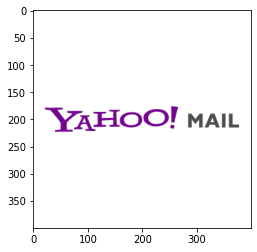

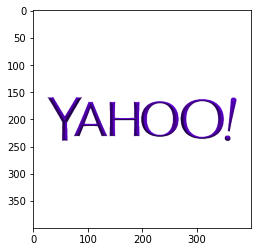

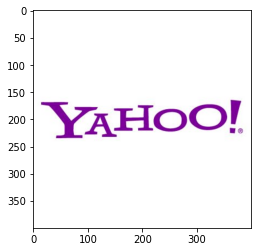

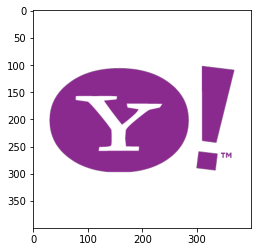

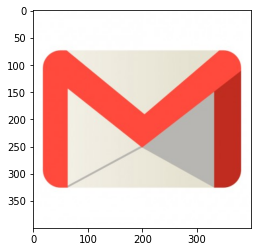

In [14]:
show_images("C:\\Users\\anike\\OneDrive\\Desktop\\Weaviate\\Demo3\\Logos\\yahoo-mail-vector-logo-400x400.png")

As you can see above, when I called the function with a path of an image of YAHOO Logo, it returned five similar images 

In [15]:
def show_images_by_text(name):
    nearText = {"concepts": name}
    result = client.query.get("Logo", ["image"]).with_near_text(nearText)\
            .with_limit(5).do()
    for i in range(5):
        some = result['data']['Get']['Logo'][i]['image']
        res = bytes(some, 'utf-8')
        f = open('output.bin','wb')
        f.write(res)
        f.close()
        file = open("output.bin",'rb')
        b = file.read()
        file.close()
        fh= open('ab.jpg','wb')
        fh.write(base64.b64decode(b))
        fh.close()
        img = mpimg.imread('ab.jpg')
        imgplot = plt.imshow(img)
        plt.show()
        
    
    

By the similar concept, **show_images_by_text** function will take text query and will return top 5 results using nearText search operator

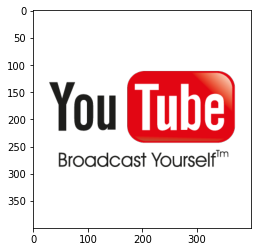

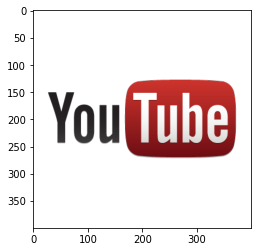

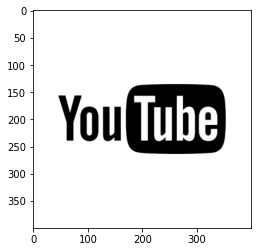

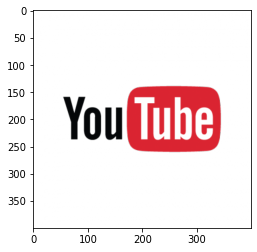

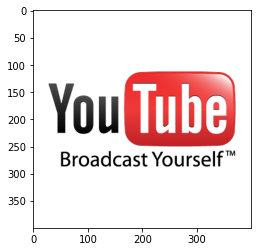

In [16]:
show_images_by_text("youtube")